## <center>CSE 546: Reinforcement Learning</center>
### <center>Prof. Alina Vereshchaka</center>
<!-- ### <center>Fall 2022</center> -->

Welcome to the Assignment 2, Part 1: Introduction to Deep Reinforcement Learning and Neural Networks! The goal of this assignment is to make you comfortable with the application of different Neural Network structures depending on how the Reinforcement Learning environment is set up.

In [243]:
# Imports
from environment import WumpusWorldEnvironment 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import gym
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import random
import torch
import pickle
import time
from IPython.display import display, clear_output

# Environment

We will be working with an implementation of the Wumpus World environment. The environment comes from the book "Artificial Intelligence: A Modern Approach" by Stuart J. Russell and Peter Norvig. 

### ENVIRONMENT DETAILS:

The environment is a 6 x 6 grid world containing a total of 36 grid blocks. 

#### ENVIRONMENT OBJECTS:
The environment consists of the following objects:

1. **Agent** - The agent starts in the grid block at the bottom left corner whose co-ordinates are [0, 0]. The goal of our agent is to collect the Gold while avoiding the Wumpus and the pits. 

2. **Wumpus** - The monster which would eat the agent if they are in the same grid block.

3. **Pit** - The agent must avoid falling into the pits. 

4. **Gold** - The agent must collect the Gold.

5. **Breeze** - Breeze surrounds the Pits and warn the agent of a Pit in an adjacent grid block.

6. **Stench** - Stench surrounds the Wumpus and warns the agent of the Wumpus in an adjacent grid block.

#### ENVIRONMENT OBSERVATIONS:

Our implementation of the environment provides you with four different types of observations:

1. **Integer** - Integer in the range [0 - 35]. This represents the grid block the agent is in. E.g., if the agent is in the bottom left grid block (starting position) the observation would be 0, if the agent is in the grid block containing the Gold the observation would be 34, if the agent is in the top right grid block the observation would be 35.

2. **Vector** - 

    **2.1.** A vector of length 2 representing the agent co-ordinates. The first entry represents the x co-ordinate and the second entry represets the y co-ordinate. E.g., if the agent is in the bottom left grid block (starting position) the observation would be [0, 0], if the agent is in the grid block containing the Gold the observation would be [4, 5], if the agent is in the top right grid block the observation would be [5, 5].
    
    **2.2.** A vector of length 36 representing the one-hot encoding of the integer observation (refer type 1 above). E.g., if the agent is in the bottom left grid block (starting position) the observation would be [1, 0, ..., 0, 0], if the agent is in the grid block containing the Gold the observation would be [0, 0, ..., 1, 0], if the agent is in the top right grid block the observation would be [0, 0, ..., 0, 1].


3. **Image** - Image render of the environment returned as an NumPy array. The image size is 84 * 84 (same size used in the DQN paper). E.g., if the agent is in the bottom right grid block the observation is:

    Observation: (84 * 84)

     [[255 255 255 ... 255 255 255]

     [255 255 255 ... 255 255 255]

     [255 255 255 ... 255 255 255]

     ...

     [255 255 255 ... 255 255 255]

     [255 255 255 ... 255 255 255]

     [255 255 255 ... 255 255 255]]

    Observation type: <class 'numpy.ndarray'>

    Observation Shape: (84, 84)

    Visually, it looks like:
    <img src="./images/environment_render.png" width="500" height="500">
    

4. **Float** - Float in the range [0 - $\infty$] representing the time elapsed in seconds. 

#### ENVIRONMENT ACTIONS:

Our implementation of the environment provides you with three different types of actions:

1. **Discrete** - Integer in the range [0 - 3] representing the four actions possible in the environment as follows: 0 - Right 1 - Left 2 - Up 3 - Down.

2. **Multi-Discrete** - Array of length four where each element takes binary values 0 or 1. Array elements represent if we take a particular action. Array element with index 0 corresponds to the right action, index 1 corresponds to the left action, index 2 corresponds to the up action, and index 3 corresponds to the down action. E.g., 
   action = [1, 0, 0, 0] would result in the agent moving right.
   action = [1, 0, 1, 0] would result in the agent moving right and up.
   action = [0, 1, 0, 1] would result in the agent moving left and down.

3. **Continuous** - Float in the range [-1, 1] determining whether the agent will go left, right, up, or down as follows:

    if -1 <= action <= -0.5:
        Go Right.
    elif -0.5 < action <= 0:
        Go Left.
    elif 0 < action <= 0.5:
        Go Up.
    elif 0.5 < action <= 1:
        Go Down.
        
### YOUR TASK IS TO USE A NEURAL NETWORK TO WORK WITH ALL FOUR TYPES OF OBSERVATIONS AND ALL THREE TYPES OF  ACTIONS.
### Note: You don't have to train your agent/neural network. You just have to build the neural network structure that takes the observation as input and produces the desired output with the initial weights.

#### You can use libraries such as PyTorch/TensorFlow/Keras to build your neural networks.

#### <span style="color:red">You cannot use RL libraries that already provide the neural network to you such as Stable-baselines3, Keras-RL, TF agents, Ray RLLib etc.</span>

<img src="./images/wumpus_world_environment.jpg" width="600" height="600">

# START COMPLETING YOUR ASSIGNMENT HERE

## Observation Type - Integer, Action Type - Discrete

The part of the assignment requires you to create a sequential dense neural network with 1 hidden layer having 64 neurons and the output layer having 4 neurons. The input to the neural network is an integer (refer to environment observations type 1). The output of the neural network is an array represeting the Q-values from which you will choose an action (refer to environment actions type 1).

The following figure shows the network structure you will have to use:

<img src="./images/neural_network_structures/neural_network_1_64_4.png">

In [244]:
"""TO DO: Create a neural network, pass it the observation from the environment
and get the predicted Q-values for the four actions. Print the observation and the Q-values."""

environment = WumpusWorldEnvironment(observation_type='integer', action_type='discrete')
observation, _ = environment.reset()

# BEGIN_YOUR_CODE
import torch
import torch.nn as nn

class NN_one(nn.Module):
    def __init__(self):
        super(NN_one, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 4)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

DiscreteIntegerenvironment = WumpusWorldEnvironment(observation_type='integer', action_type='discrete')
observation, _ = DiscreteIntegerenvironment.reset()
tensored = torch.tensor([observation], dtype=torch.float32)
model_one = NN_one()
Q_values = model_one(tensored)

print("Observation:", observation) # im guessing first state assigned is always 0
print("Q-values:", Q_values)
# END_YOUR_CODE

Observation: 0
Q-values: tensor([ 0.4871,  0.2436, -0.1871,  0.2601], grad_fn=<ViewBackward0>)


## Observation Type - Vector (2.1), Action Type - Discrete

The part of the assignment requires you to create a sequential dense neural network with 1 hidden layer having 64 neurons and the output layer having 4 neurons. The input to the neural network is a vector of length 2 (refer to environment observations type 2.1). The output of the neural network is an array represeting the Q-values from which you will choose an action (refer to environment actions type 1).

The following figure shows the network structure you will have to use:

<img src="./images/neural_network_structures/neural_network_2_64_4.png">

In [245]:
"""TO DO: Create a neural network, pass it the observation from the environment
and get the predicted Q-values for the four actions. Print the observation and the Q-values."""

environment = WumpusWorldEnvironment(observation_type='vector', action_type='discrete')
observation, _ = environment.reset()

# BEGIN_YOUR_CODE
class NN_two(nn.Module):
    def __init__(self):
        super(NN_two, self).__init__()
        self.fc1 = nn.Linear(2, 64) # 2 inputs
        self.fc2 = nn.Linear(64, 4)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

VectorDiscreteEnvironment = WumpusWorldEnvironment(observation_type='vector', action_type='discrete')
observation, _ = VectorDiscreteEnvironment.reset()
tensored = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
model_two = NN_two()
Q_values = model_two(tensored)

print("Observation:", observation)
print("Observation shape:", observation.shape)
print("Q-values:", Q_values)
# END_YOUR_CODE

Observation: [0 0]
Observation shape: (2,)
Q-values: tensor([[-0.3310,  0.3913,  0.1534, -0.3298]], grad_fn=<AddmmBackward0>)


## Observation Type - Vector (2.2), Action Type - Discrete

The part of the assignment requires you to create a sequential dense neural network with 1 hidden layer having 64 neurons and the output layer having 4 neurons. The input to the neural network is a vector of length 36 (refer to environment observations type 2.2). The output of the neural network is an array represeting the Q-values from which you will choose an action (refer to environment actions type 1).

**HINT:** Use the integer observation and convert it to a one-hot encoded vector.

The following figure shows the network structure you will have to use:

<img src="./images/neural_network_structures/neural_network_36_64_4.png">

In [246]:
"""TO DO: Create a neural network, pass it the observation from the environment
and get the predicted Q-values for the four actions. Print the observation and the Q-values."""

environment = WumpusWorldEnvironment(observation_type='integer', action_type='discrete')
observation, _ = environment.reset()

# BEGIN_YOUR_CODE
class NN_three(nn.Module):
    def __init__(self):
        super(NN_three, self).__init__()
        self.fc1 = nn.Linear(36, 64) # 36 inputs
        self.fc2 = nn.Linear(64, 4)  # linear activation for 4 units
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Thirty6Environment = WumpusWorldEnvironment(observation_type='integer', action_type='discrete')
observation, _ = Thirty6Environment.reset()

# Use the integer observation and convert it to a one-hot encoded vector.
one_hot_encoded = torch.zeros(36)
one_hot_encoded[observation] = 1
model_three = NN_three()
add_dimension = one_hot_encoded
Q_values = model_three(add_dimension)

print("Observation:", one_hot_encoded)
print("Observation shape:", one_hot_encoded.shape)
print("Q-values:", Q_values)
# END_YOUR_CODE

Observation: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Observation shape: torch.Size([36])
Q-values: tensor([ 0.0253,  0.2075, -0.0158,  0.0832], grad_fn=<ViewBackward0>)


## Observation Type - Image, Action Type - Discrete

The part of the assignment requires you to create a convolutional neural network with one convolutional layer having 128 filters of size 3 x 3, one hidden layer having 64 neurons, and the output layer having 4 neurons. The input to the neural network is an image of size 84 * 84 (refer to environment observations type 3). The output of the neural network is an array represeting the Q-values from which you will choose an action (refer to environment actions type 1).

The following figure shows the network structure you will have to use:

<img src="./images/neural_network_structures/convolutional_neural_network_84x84_128_64_4.png">

In [247]:
"""TO DO: Create a neural network, pass it the observation from the environment
and get the predicted Q-values for the four actions. Print the observation and the Q-values."""

environment = WumpusWorldEnvironment(observation_type='image', action_type='discrete')
observation, _ = environment.reset()

# BEGIN_YOUR_CODE
class NN_four_Convo(nn.Module):
    def __init__(self):
        super(NN_four_Convo, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(84 * 84 * 128, 64)
        self.fc2 = nn.Linear(64, 4) #linear activation for 4 output units

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

ConvolutionalEnvironment = WumpusWorldEnvironment(observation_type='image', action_type='discrete')
observation, _ = ConvolutionalEnvironment.reset()

# Convert to a tensor
tensored = torch.tensor(observation, dtype=torch.float32)

# Add a dimension for the batch and we might need another as its a 2d convolutional layer
tensored = tensored.unsqueeze(0).unsqueeze(0)
model_four = NN_four_Convo()
# print(model_four) # Checking model architecture
Q_values = model_four(tensored)

print("Observation:", observation)
print("Observation shape:", observation.shape)
print("Q-values:", Q_values)

# END_YOUR_CODE

Observation: [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
Observation shape: (84, 84)
Q-values: tensor([[11.0762,  1.1628, 27.2143, 19.4027]], grad_fn=<AddmmBackward0>)


## Observation Type - Float, Action Type - Discrete

The part of the assignment requires you to create a sequential dense neural network with 1 hidden layer having 64 neurons and the output layer having 4 neurons. The input to the neural network is a float (refer to environment observations type 4). The output of the neural network is an array representing the Q-values from which you will choose an action (refer to environment actions type 1).

The following figure shows the network structure you will have to use:

<img src="./images/neural_network_structures/neural_network_1_64_4.png">

In [248]:
"""TO DO: Create a neural network, pass it the observation from the environment
and get the predicted Q-values for the four actions. Print the observation and the Q-values."""

environment = WumpusWorldEnvironment(observation_type='float', action_type='discrete')
observation, _ = environment.reset()

# BEGIN_YOUR_CODE
class NN_five(nn.Module):
    def __init__(self):
        super(NN_five, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 4)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

FloatDiscreteEnvironment = WumpusWorldEnvironment(observation_type='float', action_type='discrete')
observation, _ = FloatDiscreteEnvironment.reset()
tensored = torch.tensor([observation])
model_five = NN_five()
Q_values = model_five(tensored)

print("Observation:", observation)
print("Q-values:", Q_values)

# END_YOUR_CODE

Observation: 0.0
Q-values: tensor([-0.2165,  0.0098,  0.0962, -0.3527], grad_fn=<ViewBackward0>)


## Observation Type - Vector (2.2), Action Type - Multi-Discrete

The part of the assignment requires you to create a sequential dense neural network with 1 hidden layer having 64 neurons and the output layer having 4 neurons. The input to the neural network is a vector of length 36 (refer to environment observations type 2.2). The output of the neural network is an array representing the probability of choosing the actions. (If the value of the array element is >=0.5 you will perform the action.) (refer to environment actions type 2).

**HINT:** Use the integer observation and convert it to a one-hot encoded vector.

The following figure shows the network structure you will have to use:

<img src="./images/neural_network_structures/neural_network_36_64_4_sigmoid.png">

In [249]:
"""TO DO: Create a neural network, pass it the observation from the environment
and get the predicted action probabilities for the four actions. Print the observation and the action probabilities."""

environment = WumpusWorldEnvironment(observation_type='integer', action_type='multi_discrete')
observation, _ = environment.reset()

# BEGIN_YOUR_CODE
class NN_six(nn.Module):
    def __init__(self):
        super(NN_six, self).__init__()
        self.fc1 = nn.Linear(36, 64) # input units 36
        self.fc2 = nn.Linear(64, 4)  #output units : 4
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for ^^

    def forward(self, x):
        x = torch.relu(self.fc1(x)) #for hidden
        x = self.sigmoid(self.fc2(x))  #for output
        return x

VectorActionEnvironment = WumpusWorldEnvironment(observation_type='integer', action_type='multi_discrete')
observation, _ = VectorActionEnvironment.reset()
one_hot_encoded = torch.zeros(36)
one_hot_encoded[observation] = 1
model_six = NN_six()
action_probablities = model_six(one_hot_encoded)

print("Observation:", observation)
print("Action Probabilities:", action_probablities)

# END_YOUR_CODE

Observation: 0
Action Probabilities: tensor([0.5013, 0.4605, 0.4960, 0.4946], grad_fn=<SigmoidBackward0>)


## Observation Type - Vector (2.2), Action Type - Continuous

The part of the assignment requires you to create a sequential dense neural network with 1 hidden layer having 64 neurons and the output layer having 1 neuron. The input to the neural network is a vector of length 36 (refer to environment observations type 2.2). The output of the neural network is an float in the range [-1, 1] determining the action which will be taken. (refer to environment actions type 3).

**HINT:** Use the integer observation and convert it to a one-hot encoded vector and use the TanH activation function to get the output in the range [-1, 1].

The following figure shows the network structure you will have to use:

<img src="./images/neural_network_structures/neural_network_36_64_1.png">

In [250]:
"""TO DO: Create a neural network, pass it the observation from the environment
and get the predicted action. Print the observation and the predicted action."""

environment = WumpusWorldEnvironment(observation_type='integer', action_type='continuous')
observation, _ = environment.reset()

# BEGIN_YOUR_CODE
class NN_seven(nn.Module):
    def __init__(self):
        super(NN_seven, self).__init__()
        self.fc1 = nn.Linear(36, 64)
        self.fc2 = nn.Linear(64, 1)
        self.tanh = nn.Tanh()  #tanh activation on just 1 unit

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.tanh(self.fc2(x))
        return x

# Is this correct? Please let us know in feedback. Thank you!

environment = WumpusWorldEnvironment(observation_type='integer', action_type='continuous')
observation, _ = environment.reset()
one_hot_encoded = torch.zeros(36)
one_hot_encoded[observation] = 1
model_six = NN_seven()
actions = model_six(one_hot_encoded)

print("Observation:", one_hot_encoded)
print("Observation shape:", one_hot_encoded.shape)
print("Predicted Action:", actions.item())
# END_YOUR_CODE

Observation: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Observation shape: torch.Size([36])
Predicted Action: -0.048573851585388184


##Part II [50 points] - Implementing DQN & Solving Various Problems

Source - https://arxiv.org/pdf/1312.5602\

In [251]:
# #Define DQN NN
# class DQN(nn.Module):
#     def __init__(self, input_dimensions, output_dimensions):
#       super(DQN, self).__init__()
#       self.fc1 = nn.Linear(input_dimensions, 64)
#       self.fc2 = nn.Linear(64, 64)
#       self.fc3 = nn.Linear(64, output_dimensions)

#     #same as all the others but relu as its better for DQN
#     def forward(self, x):
#       x = torch.relu(self.fc1(x))
#       x = torch.relu(self.fc2(x))
#       return self.fc3(x)

In [252]:

# #Initialize replay memory D to capacity N
# class Replay:
#     def __init__(self, capacityN):
#       self.tracker = deque(maxlen=capacityN)
    
#     def push(self, s, a, r, s_, mission_accomplished):
#       transition = (s, a, r, s_, mission_accomplished)
#       self.tracker.append(transition)     # Add the transition to the buffer
    
#     def Sample(self, batch_len):
#       # Randomly pick a batch of transitions from the buffer
#       transitions = random.sample(self.tracker, batch_len)
#       states = actions = rewards = states_ = missions_accomplished = []

#       for transition in transitions:
#         s, a, r, s_, mission_accomplished = transition
#         states.append(s)
#         actions.append(a)
#         rewards.append(r)
#         states_.append(s_)
#         missions_accomplished.append(mission_accomplished)
      
#       states = np.array(states)
#       actions = np.array(actions)
#       rewards = np.array(rewards, dtype=np.float32)
#       states_ = np.array(states_)
#       missions_accomplished = np.array(missions_accomplished, dtype=np.uint8)

#       return states, actions, rewards, states_, missions_accomplished

In [253]:

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define DQN Neural Network
class DQN(nn.Module):
    def __init__(self, input_dimensions, output_dimensions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dimensions, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dimensions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define Replay Memory
class Replay:
    def __init__(self, capacityN):
        self.tracker = deque(maxlen=capacityN)

    def push(self, s, a, r, s_, mission_accomplished):
        transition = (s, a, r, s_, mission_accomplished)
        self.tracker.append(transition)

    def sample(self, batch_len):
        transitions = random.sample(self.tracker, batch_len)
        batch = list(zip(*transitions))
        return (np.vstack(batch[0]), np.array(batch[1]), np.array(batch[2], dtype=np.float32),
                np.vstack(batch[3]), np.array(batch[4], dtype=np.uint8))

Using device: cpu


In [254]:
class DeterministicWarehouseRobotEnv(gym.Env):
    metadata = {'render.modes': []}

    def __init__(self):
        self.grid_size = 6 #6x6 grid
        self.start = [0, 0]
        self.pickup = [3, 3]
        self.end = [5, 5] # drop off location4
        self.agent_position = self.start.copy()
        self.obstacles = [(1, 3), (4, 2), (3,5),(4, 4)]
        self.picked_up_or_not = False
        self.actions = ["up", "down", "left", "right", "pick-up", "drop-off"]  # Up, Down, Left, Right, Pick-up, Drop-off
        self.observation_space = spaces.Dict({
            'agent_position': spaces.Tuple((spaces.Discrete(6), spaces.Discrete(6))), #coordinates could be any number between 0-5
            'agent_picked_up_or_not': spaces.Discrete(2) # 0 = not picked and 1 = picked
        })
        # Rewards
        self.reward_for_delivery = 100
        self.reward_pickup = 25
        self.reward_step = -1
        self.obstacle_penalty = -20
        self.invalid_Pickup_pentalty = -5
        self.invalid_Dropoff_pentalty = -5
        #self.q_table = {} not needed for part 1 checkpoint

    def reset(self):
        self.agent_position = self.start.copy()
        self.picked_up_or_not = False
        observation = {
            'agent_position': tuple(self.agent_position),
            'agent_picked_up_or_not': self.picked_up_or_not
        }
        return observation, {}

    def step(self, action):
      reward = self.reward_step
      mission_accomplished = False
      new_position = self.agent_position.copy()
      #actions
      if action == "up":  # Up
          new_position[0] -= 1
      elif action == "down":  # Down
          new_position[0] += 1
      elif action == "left":  # Left
          new_position[1] -= 1
      elif action == "right":  # Right
          new_position[1] += 1
      elif action == "pick-up":  # Pick-up
          if tuple(self.agent_position) == tuple(self.pickup) and not self.picked_up_or_not:
              self.picked_up_or_not = True
              reward += self.reward_pickup
          else:
              reward += self.invalid_Pickup_pentalty
      elif action == "drop-off":  # Drop-off
          if tuple(self.agent_position) == tuple(self.end) and self.picked_up_or_not:
              self.picked_up_or_not = False
              reward += self.reward_for_delivery
              mission_accomplished = True
          else:
              reward += self.invalid_Dropoff_pentalty
      # Check for collisions with obstacles or boundaries
      if tuple(new_position) in self.obstacles:
          reward += self.obstacle_penalty
      elif not (0 <= new_position[0] < 6 and 0 <= new_position[1] < 6):
          reward += self.obstacle_penalty
      else:
          self.agent_position = new_position
      # Observation
      observation = {
          'agent_position': tuple(self.agent_position),
          'agent_picked_up_or_not': self.picked_up_or_not
      }
      return observation, reward, mission_accomplished, False, {}

    def render(self):
      grid = np.zeros((6, 6))
      for obstacle in self.obstacles:
          grid[obstacle] = -1
      if not self.picked_up_or_not:
          grid[tuple(self.agent_position)] = 1
      else:
          grid[tuple(self.agent_position)] = 2
      grid[self.pickup[0], self.pickup[1]] = 3
      grid[self.end[0], self.end[1]] = 4
      plt.imshow(grid)
      plt.title('Warehouse Robot Environment')
      plt.show()

In [255]:
BATCH_SIZE = 128
GAMMA = 0.75
EPS_START = 1.0
EPS_END = 0.00
EPS_DECAY = 0.98
TARGET_UPDATE = 2
LEARNING_RATE = 0.015
MEMORY_CAPACITY = 100000
NUM_EPISODES = 1000

In [256]:
# Initialize environment, DQN, and replay memory
env = DeterministicWarehouseRobotEnv()
input_dimensions = 3  # (x, y, picked_up_or_not)
output_dimensions = 6  # 6 actions: up, down, left, right, pick-up, drop-off
primary_net = DQN(input_dimensions, output_dimensions).to(device)
target_net = DQN(input_dimensions, output_dimensions).to(device)
target_net.load_state_dict(primary_net.state_dict())
target_net.eval()
optimizer = optim.Adam(primary_net.parameters(), lr=LEARNING_RATE)
memory = Replay(MEMORY_CAPACITY)

# Epsilon-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 5)  # Random action
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        return primary_net(state_tensor).argmax().item()
    
def pickle_model(model, filename):
    with open(filename,'wb') as f:
        pickle.dump(model.state_dict(), f)

# Training step
def train_step():
    if len(memory.tracker) < BATCH_SIZE:
        return
    states, actions, rewards, states_, missions_accomplished = memory.sample(BATCH_SIZE)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    states_ = torch.FloatTensor(states_).to(device)
    missions_accomplished = torch.FloatTensor(missions_accomplished).to(device)
    # Compute Q-values for current states
    Q_current = primary_net(states).gather(1, actions.unsqueeze(1))
    # Compute Q-values for next states using the target network
    Q_next = target_net(states_).max(1)[0].detach()
    Q_target = rewards + GAMMA * Q_next * missions_accomplished
    # Compute loss and update the primary network
    loss = F.mse_loss(Q_current, Q_target.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
epsilon = EPS_START
rewards_per_episode, epsilon_values = [], []
for episode in range(NUM_EPISODES):
    observation, _ = env.reset()
    state = np.array([*observation['agent_position'], observation['agent_picked_up_or_not']])  # Flatten state
    total_reward = 0
    done = False
    while not done:
        action = select_action(state, epsilon)
        observation_, reward, mission_accomplished, _, _ = env.step(env.actions[action])
        next_state = np.array([*observation_['agent_position'], observation_['agent_picked_up_or_not']])  # Flatten next state
        memory.push(state, action, reward, next_state, not mission_accomplished)
        state = next_state
        total_reward += reward
        if mission_accomplished:
            done = True
        train_step()
    # Decay epsilon
    epsilon = max(EPS_END, epsilon * EPS_DECAY)
    epsilon_values.append(epsilon)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(primary_net.state_dict())
    rewards_per_episode.append(total_reward)
    print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

# Pickle weights
timestamp = time.strftime("%Y-%m-%d_%H-%M")
filename = f"DQN_{timestamp}.pickle"
pickle_model(primary_net, filename)
print(f"Model saved as {filename}")

Episode 1, Total Reward: -2598, Epsilon: 0.98
Episode 2, Total Reward: -1731, Epsilon: 0.96
Episode 3, Total Reward: -3827, Epsilon: 0.94
Episode 4, Total Reward: -3905, Epsilon: 0.92
Episode 5, Total Reward: -5255, Epsilon: 0.90
Episode 6, Total Reward: -2329, Epsilon: 0.89
Episode 7, Total Reward: -666, Epsilon: 0.87
Episode 8, Total Reward: -566, Epsilon: 0.85
Episode 9, Total Reward: -588, Epsilon: 0.83
Episode 10, Total Reward: -577, Epsilon: 0.82
Episode 11, Total Reward: -53, Epsilon: 0.80
Episode 12, Total Reward: -107, Epsilon: 0.78
Episode 13, Total Reward: -270, Epsilon: 0.77
Episode 14, Total Reward: -1574, Epsilon: 0.75
Episode 15, Total Reward: -279, Epsilon: 0.74
Episode 16, Total Reward: -568, Epsilon: 0.72
Episode 17, Total Reward: -4, Epsilon: 0.71
Episode 18, Total Reward: -56, Epsilon: 0.70
Episode 19, Total Reward: -42, Epsilon: 0.68
Episode 20, Total Reward: -135, Epsilon: 0.67
Episode 21, Total Reward: 44, Epsilon: 0.65
Episode 22, Total Reward: -85, Epsilon: 0.6

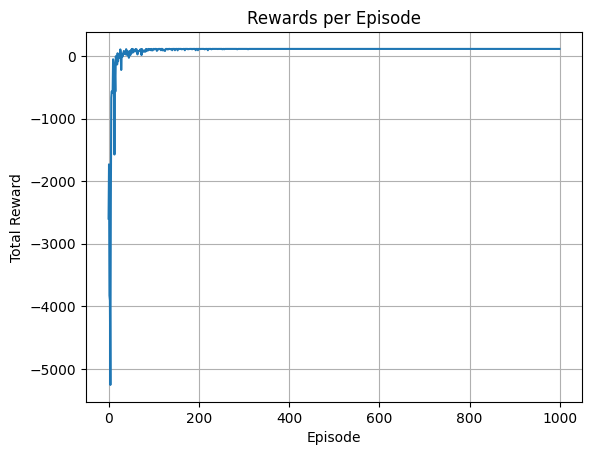

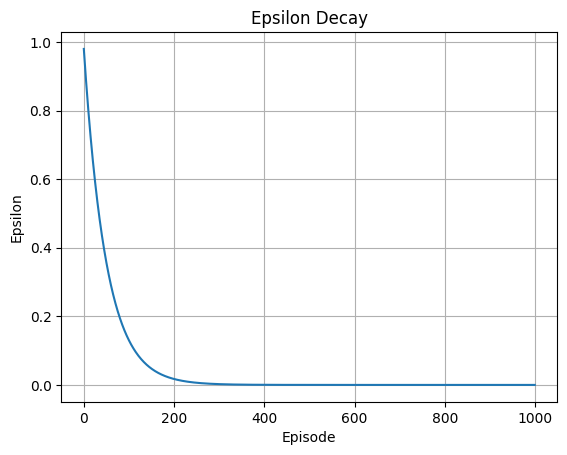

In [257]:
# Plot rewards
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.grid()
plt.show()

plt.plot(epsilon_values)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.grid()
plt.show()